# Model Book 2

In [18]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import lightgbm as lgb
from tensorflow import keras
from matplotlib.colors import LinearSegmentedColormap
import onnxmltools
from onnxmltools.convert.lightgbm import convert
from onnxmltools.utils import save_model

import warnings 
warnings.filterwarnings('ignore')


In [4]:
test_transactions = pd.read_csv(r'datasets/test_transaction.csv')
test_identity = pd.read_csv(r'datasets/test_identity.csv')
train_transactions = pd.read_csv(r'datasets/train_transaction.csv')
train_identity = pd.read_csv(r'datasets/train_identity.csv')

# merge train and test datasets independently on 'TransactionID'
train_data = train_transactions.merge(train_identity, on='TransactionID', how='left')
test_data = test_transactions.merge(test_identity, on='TransactionID', how='left')

# delete unused objects to save memory
del test_transactions, train_transactions, train_identity, test_identity


In [ ]:
# Save to a CSV file (IF NOT DONE)
output_file = 'train_data.csv'
train_data.to_csv(output_file, index=False)
print(f'Data saved to {output_file}.')

In [6]:
# Load the dataset
data_path = r'datasets\train_data.csv' 
data = pd.read_csv(data_path)

# Display basic information about the dataset
print('Dataset Info:')
data.info(verbose=True, memory_usage=True, show_counts=True)

# Checking for missing values
missing_values = data.isnull().sum()
print('\nMissing Values:')
print(missing_values[missing_values > 0])

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 434 columns):
 #    Column          Non-Null Count   Dtype  
---   ------          --------------   -----  
 0    TransactionID   590540 non-null  int64  
 1    isFraud         590540 non-null  int64  
 2    TransactionDT   590540 non-null  int64  
 3    TransactionAmt  590540 non-null  float64
 4    ProductCD       590540 non-null  object 
 5    card1           590540 non-null  int64  
 6    card2           581607 non-null  float64
 7    card3           588975 non-null  float64
 8    card4           588963 non-null  object 
 9    card5           586281 non-null  float64
 10   card6           588969 non-null  object 
 11   addr1           524834 non-null  float64
 12   addr2           524834 non-null  float64
 13   dist1           238269 non-null  float64
 14   dist2           37627 non-null   float64
 15   P_emaildomain   496084 non-null  object 
 16   R_emaildomain   137291

### Visualization

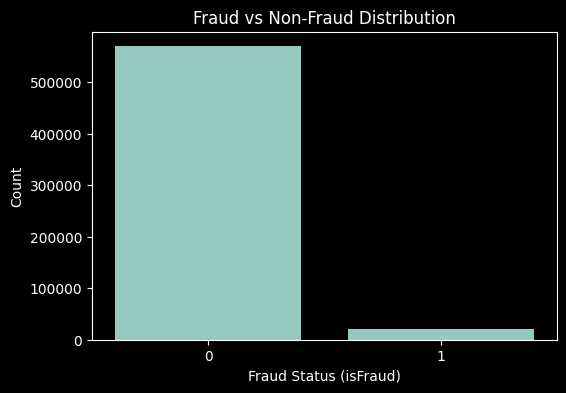

Fruad: isFraud
0    569877
1     20663
Name: count, dtype: int64
3.50% of transactions are fraud


In [7]:
plt.style.use('dark_background')

# Plot Target Variable (isFraud)
plt.figure(figsize=(6, 4))  # Initialize the plot with figure size
sns.countplot(x='isFraud', data=data)  # Count plot for fraud vs non-fraud
plt.title('Fraud vs Non-Fraud Distribution')
plt.xlabel('Fraud Status (isFraud)')
plt.ylabel('Count')
plt.show()

fraud_count = data['isFraud'].value_counts()
print(f'Fruad: {fraud_count}')

# Optionally, display the counts more descriptively
fraud_percentage = (fraud_count[1] / (fraud_count[0] + fraud_count[1])) * 100
print(f'{fraud_percentage:.2f}% of transactions are fraud')


In [28]:
def make_heatmap(impotant_data2, impotant_data3):    
    
    data2 = impotant_data2
    data3 = impotant_data3

    plt.style.use('dark_background')

    # Style stuff
    colors = ['white', 'purple']
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    more_than_o2_size = {'size':4}
    more_than_o3_size = {'size':12}

    # Now we can plot both heat maps
    plt.figure(figsize=(10, 8))
    sns.heatmap(data2.corr(), annot=True, cmap=custom_cmap, fmt='.2f', annot_kws=more_than_o2_size)
    plt.title('Heatmap of Important Features Correlated > 0.2 with isFraud', color='white')
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(data3.corr(), annot=True, cmap=custom_cmap, fmt='.2f', annot_kws=more_than_o3_size)
    plt.title('Heatmap of Important Features Correlated > 0.3 with isFraud', color='white')
    plt.show()

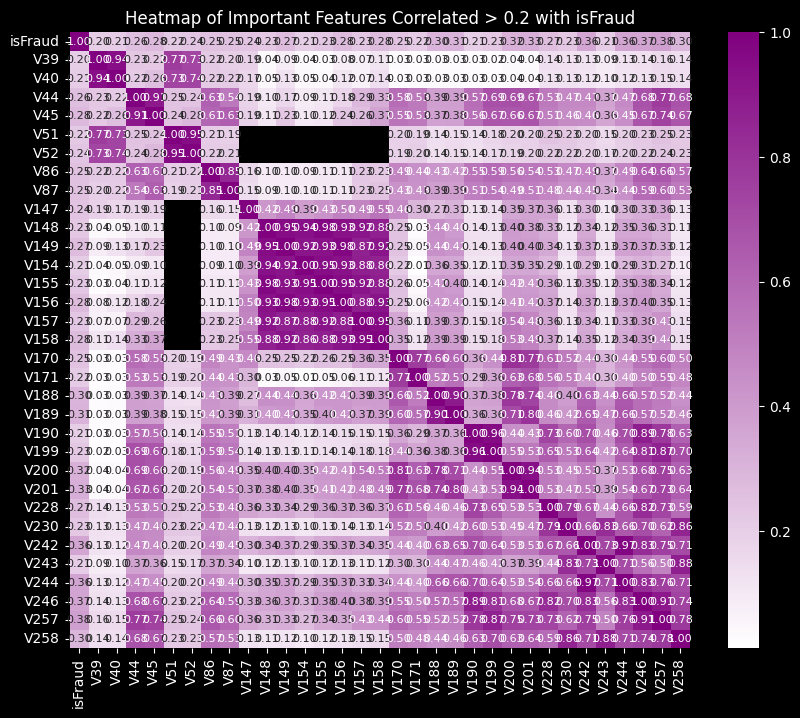

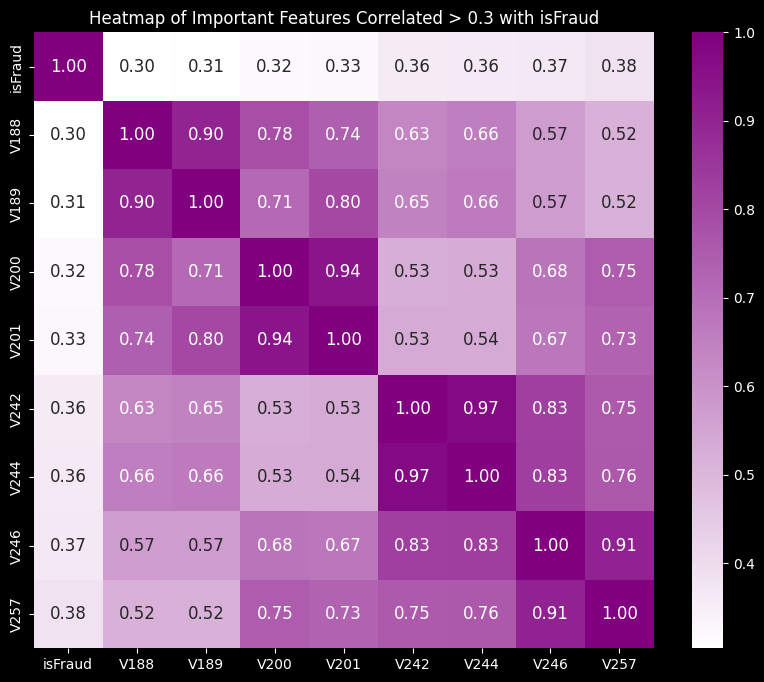

In [29]:
def heatmap_on_data(data):
    numeric_data = data.select_dtypes(include=['number'])
    # compute the correlations of all quantitative data with 'isFruad'
    correlation_matrix = numeric_data.corr()

    # only take the important columns that have correlation coefficients above 0.1 or below -0.1
    important_columns2 = correlation_matrix['isFraud'][abs(correlation_matrix['isFraud']) > 0.2].index
    important_columns3 = correlation_matrix['isFraud'][abs(correlation_matrix['isFraud']) > 0.3].index

    important_data2 = numeric_data[important_columns2]
    important_data3 = numeric_data[important_columns3]
    make_heatmap(important_data2, important_data3)

heatmap_on_data(data)

### Data Preprocessing


In [8]:
# Filling missing values and encoding categorical variables
for column in data.select_dtypes(include=['object']).columns:
    data[column].fillna('unknown', inplace=True)
    data[column] = LabelEncoder().fit_transform(data[column])

# Imputing missing numerical values with median
for column in data.select_dtypes(include=['number']).columns:
    data[column].fillna(data[column].median(), inplace=True)


In [9]:
# Splitting features and target
X = data.drop(columns=['isFraud'])  # Drop the target column
y = data['isFraud']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Run Model

In [ ]:
# LightGBM Model
lgb_train = lgb.Dataset(X_train_scaled, label=y_train)
lgb_eval = lgb.Dataset(X_test_scaled, label=y_test, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1,
    'device': 'gpu'
}

from lightgbm import early_stopping

print('Training LightGBM Model...')
lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    num_boost_round=5000,
    callbacks=[early_stopping(stopping_rounds=50)]
)



Training LightGBM Model...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4381]	training's auc: 0.999375	valid_1's auc: 0.973895


In [16]:
# Evaluate LightGBM Model
lgb_predictions = lgb_model.predict(X_test_scaled)
lgb_auc = roc_auc_score(y_test, lgb_predictions)
print(f'LightGBM Model AUC: {lgb_auc:.4f}')

LightGBM Model AUC: 0.9739


### Make and save ONNX file

In [ ]:
from onnxmltools.convert import convert_lightgbm
from skl2onnx.common.data_types import FloatTensorType
import lightgbm as lgb

# Assuming lgb_model is your trained LightGBM model
# Example: lgb_model = lgb.Booster(model_file='model.txt')

# Automatically determine the number of features
num_features = len(lgb_model.feature_name())  # Extract number of features from the LightGBM model

# Define the input schema for the model
initial_types = [('input', FloatTensorType([None, num_features]))]

# Convert the model to ONNX format
print('Converting LightGBM model to ONNX...')
onnx_model = convert_lightgbm(lgb_model, initial_types=initial_types)

# Save the ONNX model
onnx_file_path = 'lightgbm_model.onnx'
with open(onnx_file_path, 'wb') as f:
    f.write(onnx_model.SerializeToString())
print(f'LightGBM model saved as ONNX file at {onnx_file_path}')



Converting LightGBM model to ONNX...


The maximum opset needed by this model is only 9.


LightGBM model saved as ONNX file at lightgbm_model.onnx
